In [2]:
PATH = '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20120419_074803_HMI/tiles'

In [42]:
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np

In [75]:
FILES = glob.glob(PATH + '/*.jpg')

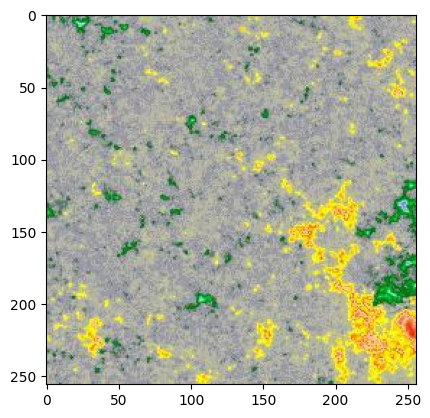

In [76]:
I = Image.open(FILES[100])
plt.imshow(np.array(I))

(256, 256, 3) 0.14901960784313728 0.6490196078431373


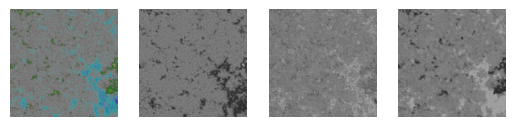

In [50]:
img = cv2.imread(FILES[100])
# img = (np.array(img).astype(float))/255.
img = (np.array(img).astype(float)-179)/255.
img = (1+img)/2
print(img.shape, img.min(), img.max())
plt.subplot(1,4,1)
plt.imshow(img,vmin=0,vmax=1)
plt.axis('off')
for i in range(3):
    plt.subplot(1,4,i+2)
    plt.imshow(img[:,:,i],cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    


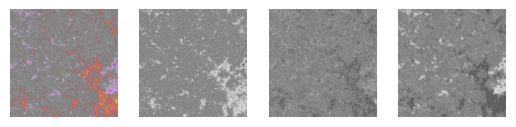

In [51]:
plt.subplot(1,4,1)
plt.imshow(1-img,vmin=0,vmax=1)
plt.axis('off')
for i in range(3):
    plt.subplot(1,4,i+2)
    plt.imshow(1-img[:,:,i],cmap='gray',vmin=0,vmax=1)
    plt.axis('off')

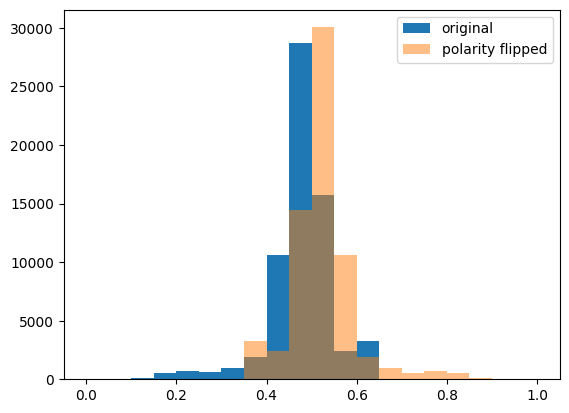

In [49]:
plt.hist(img[:,:,2].flatten(),bins=20,range = [0,1],label='original')
plt.hist(1-img[:,:,2].flatten(),alpha = 0.5,bins=20,range = [0,1],label='polarity flipped')
plt.legend()

0 : 154.0 256
10 : 178.0 256
20 : 179.0 256
40 : 154.0 256
80 : 178.0 256
160 : 154.0 256


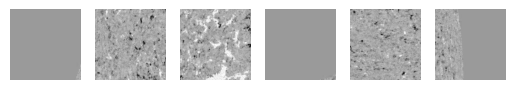

In [73]:
id_list = [0, 10, 20, 40, 80, 160]
#intensities = np.linspace(0,255,256)
for i, id in enumerate(id_list):
    img_ = cv2.imread(FILES[id])
    l = list(img_[:,:,2].flatten())
    #h = [l.count(i) for i in range(256)]
    h, b = np.histogram(img_[:,:,2].flatten(), bins = 256, range=[-0.5,255.5])
    idx = np.argmax(h)
    max_ = (b[idx] + b[idx + 1]) / 2
    #plt.hist(img_[:,:,2].flatten(), bins = 20, alpha = 0.5)
    print(id,":",max_, len(h))
    plt.subplot(1,len(id_list),i+1)
    plt.imshow(img_[:,:,2],cmap='gray',vmin=0,vmax=255)
    plt.axis('off')

In [78]:
df = {'filename':[],
      'intensity_min':[],
      'intensity_mode':[],
      'intensity_max':[],
      'offlimb_frac_area':[]}

files = glob.glob('/d0/euv/aia/preprocessed/HMI/HMI_256x256/**/*.jpg',  
                   recursive = True) 

for f in files:
      img_ = cv2.imread(f)
      l = list(img_[:,:,2].flatten())
      #h = [l.count(i) for i in range(256)]
      h, b = np.histogram(img_[:,:,2].flatten(), bins = 256, range=[-0.5,255.5])
      idx = np.argmax(h)
      mode = (b[idx] + b[idx + 1]) / 2
      frac = h[idx]/(256.*256.)
      print(f,"--",'IMODE:',mode,'IMIN:',
            img_[:, :, 2].min(),'IMAX:',
            img_[:, :, 2].max(),'OFF_frac:',frac)
      df['filename'].append(f)
      df['intensity_mode'].append(max_)
      df['intensity_min'].append(img_[:, :, 2].min())
      df['intensity_max'].append(img_[:, :, 2].max())
      df['offlimb_frac_area'].append(frac)

In [69]:
id_list.count(1)

0

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
torch.set_float32_matmul_precision("high")

import matplotlib.pyplot as plt

from lightly.data import ImageCollateFunction, LightlyDataset, collate
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import (
    SimSiamPredictionHead,
    SimSiamProjectionHead
)
from lightly.transforms import SimSiamTransform

import os
import matplotlib.offsetbox as osb

import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

from sklearn import random_projection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sdo_augmentation.augmentation_list import AugmentationList
from sdo_augmentation.augmentation import Augmentations

from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append('/home/subhamoy/search/hits-sdo-similaritysearch/')
from search_utils.image_utils import read_image, stitch_adj_imgs
from search_simsiam.custom_collate import sunbirdCollate

import glob
from tqdm import tqdm
import wandb
import random

In [11]:
stride = 1

In [12]:
dataset_train_simsiam = LightlyDataset(input_dir='/d0/euv/aia/preprocessed/HMI/HMI_256x256/')

In [13]:
if stride>1:
  indices = range(0, len(dataset_train_simsiam), stride)
  subset_train_simsiam = torch.utils.data.Subset(dataset_train_simsiam, indices)

In [14]:
len(dataset_train_simsiam)

662937

In [32]:
sun_bird_collate_fn = sunbirdCollate(path_to_data='/d0/euv/aia/preprocessed/HMI/HMI_256x256/', 
                                     fill_type='Nearest', multi_wl=True, iterative=False)

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FB73D9AE770>, 0, '20100602_074809_HMI/tiles/20100602_074809_HMI_tile_3328_2048.jpg')
tensor([0]) ['20100602_074809_HMI/tiles/20100602_074809_HMI_tile_3328_2048.jpg']


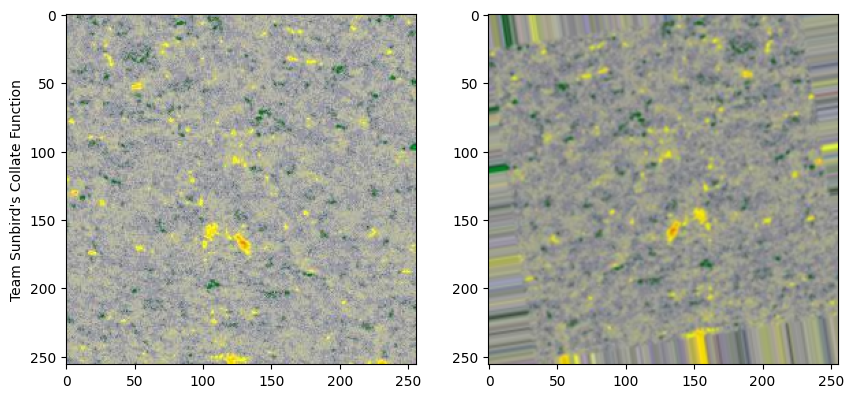

In [40]:
idx = 130
print(dataset_train_simsiam[idx])
(img_t0,img_t1),label,file_name = sun_bird_collate_fn([dataset_train_simsiam[idx]])

plt.figure(figsize = (10,10))

print(label,file_name)
plt.subplot(2,2,1)
plt.imshow(img_t0.permute(2,3,1,0)[:,:,:,0])
plt.ylabel("Team Sunbird's Collate Function")
plt.subplot(2,2,2)
plt.imshow(img_t1.permute(2,3,1,0)[:,:,:,0])

In [44]:
img_ref = cv2.imread('/home/subhamoy/search/latest_4096_HMIBC.jpg')

In [56]:
from PIL import Image
image = Image.open('/home/subhamoy/search/latest_4096_HMIBC.jpg')

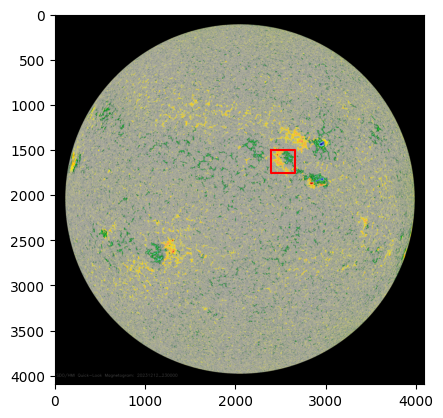

In [79]:
plt.imshow(image)
xs = [2400, 2656, 2656, 2400, 2400]
ys = [1500, 1500, 1756, 1756, 1500]
plt.plot(xs, ys, color="red")

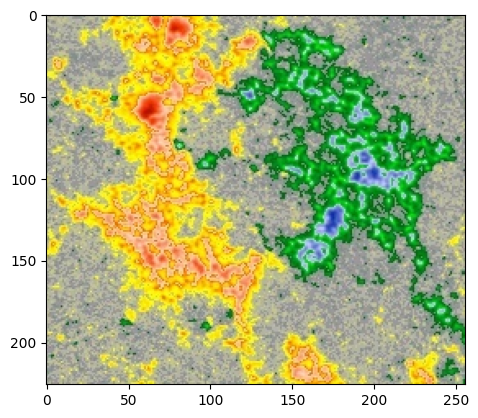

In [59]:
plt.imshow(np.array(image)[1500:1726,2400:2656,:])


In [60]:
import torchvision

In [66]:
convert_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
tensor = convert_tensor(image)
tensor = tensor[None, :3, 1500:1756,2400:2656]

In [67]:
tensor.shape

torch.Size([1, 3, 256, 256])

In [74]:
tensor.max()

tensor(1.)

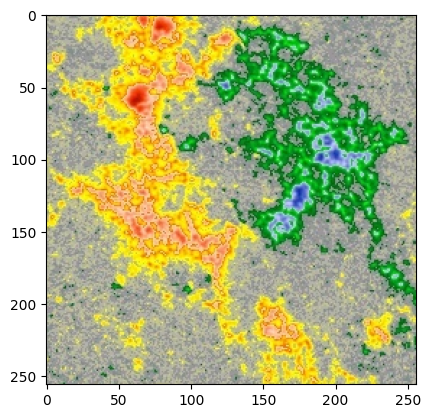

In [71]:
plt.imshow(tensor[0,:,:,:].permute(1, 2, 0))

In [69]:
np_arr.shape

(1, 3, 256, 256)

(array([ 4952.,  5848.,  5924.,  3853.,  2579.,  2046.,  2547.,  3447.,
         4989.,  6914., 12716., 19801., 25416., 15244., 22232., 10805.,
         5144.,  3330.,  6162.,  9619.]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

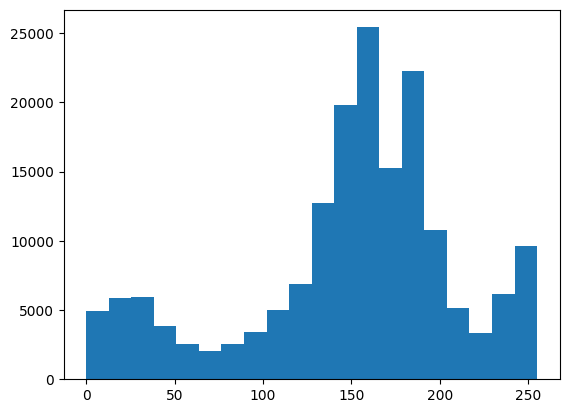

In [55]:
#plt.imshow(img_ref[1500:1726,2400:2656,::-1])
plt.hist(img_ref[1500:1726,2400:2656,::-1].flatten(),bins=20)

In [6]:
import pandas as pd 
df = pd.read_csv('/d0/subhamoy/models/search/magnetograms/indexer.csv')
list(df['filename'][df['offlimb_frac_area']<0.4])

['/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1280_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1536_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1792_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2048_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2304_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2560_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1024_768.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1280_768.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1536_768.jpg',
 '/d0/euv/aia/prepr

In [1]:
from dataset import HMItilesDataset
dataset = HMItilesDataset(data_path='/d0/euv/aia/preprocessed/HMI/HMI_256x256/',
                          augmentation='double',
                          offlimb_frac=0.4)

In [10]:
dataloader_train_simsiam = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=True,                                                                   
        # collate_fn=sun_bird_collate_fn,                                                 
        drop_last=True,                                                                 
        num_workers=4)

In [12]:
x0, x1, f =next(iter(dataloader_train_simsiam))

In [15]:
len(f)

64

In [2]:
dataset.image_files

['/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1280_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1536_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1792_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2048_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2304_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_2560_512.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1024_768.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1280_768.jpg',
 '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20100602_074809_HMI/tiles/20100602_074809_HMI_tile_1536_768.jpg',
 '/d0/euv/aia/prepr

In [3]:
len(dataset)

485160

In [4]:
img1,img2, f = dataset[0]

In [6]:
import matplotlib.pyplot as plt

In [7]:
import torch

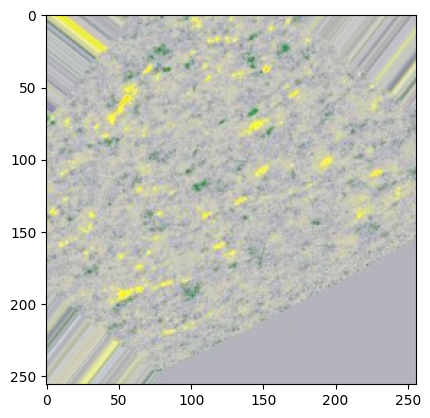

In [9]:
plt.imshow(torch.tensor(img2).permute(1, 2, 0))

In [8]:
from dataset import HMItilesDataset 
import torch
DATA_DIR = '/d0/euv/aia/preprocessed/HMI/HMI_256x256/'
dataset_train_simsiam = HMItilesDataset(data_path=DATA_DIR, augmentation='double',
                                            data_stride=1, offlimb_frac=3, step_multiplier=3,
                                            batch_size=64)

dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=64,
    shuffle=False,                                                                                                                 
    drop_last=False,                                                                 
    num_workers=4)
print(dataset_train_simsiam.image_files[10358*64:10358*64+10])
im1, im2, f = next(iter(dataloader_train_simsiam))
print(f[:10])
print(len(dataset_train_simsiam)//64,len(dataloader_train_simsiam))
    

['/d0/euv/aia/preprocessed/HMI/HMI_256x256/20180619_074800_HMI/tiles/20180619_074800_HMI_tile_3328_2304.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20131019_074802_HMI/tiles/20131019_074802_HMI_tile_512_1024.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20150404_074802_HMI/tiles/20150404_074802_HMI_tile_1536_768.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20211125_074800_HMI/tiles/20211125_074800_HMI_tile_2560_2816.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20130804_074802_HMI/tiles/20130804_074802_HMI_tile_3072_1024.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20180504_074800_HMI/tiles/20180504_074800_HMI_tile_1280_3328.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20200722_074800_HMI/tiles/20200722_074800_HMI_tile_3328_2304.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20150504_074802_HMI/tiles/20150504_074802_HMI_tile_2048_3072.jpg', '/d0/euv/aia/preprocessed/HMI/HMI_256x256/20140627_074802_HMI/tiles/20140627_074802_HMI_tile_1024_2816.jpg', '/d0/euv/aia/preproc

In [7]:
len(set(dataset_train_simsiam.image_files[2*64*10358:3*64*10358]))

662912

In [2]:
31074/3

10358.0